In [21]:
import matplotlib.pyplot as plt
import numpy as np
import wave
from random import sample
import pandas as pd
from scipy import fftpack
from scipy.signal import butter, filtfilt
from statsmodels.graphics.tsaplots import plot_acf
import plotly.graph_objects as go 
import os
from difflib import SequenceMatcher
# from tsfeatures import tsfeatures

# Plotting

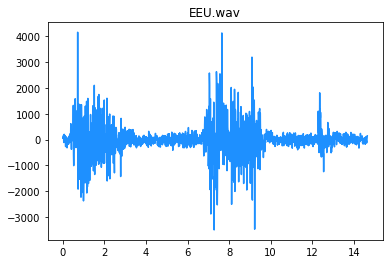

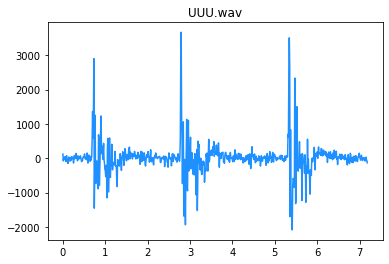

In [ ]:
def plot_wave(path):
    path = str(path)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()

    Time = np.linspace(0, len(signal) / fs, num=len(signal))

    plt.figure(1)
    title = str(path.split("arm_signal/")[-1])
    
    plt.title(title)
    plt.plot(Time[::100], signal[::100], color = 'dodgerblue')
    plt.show()

plot_wave("/Users/martinhuang/Desktop/OneDrive/2022/2022 Sem 1/DATA3888/Brain 5/Brain/arm_signal/EEU.wav")
plot_wave("/Users/martinhuang/Desktop/OneDrive/2022/2022 Sem 1/DATA3888/Brain 5/Brain/arm_signal/UUU.wav")




# Classifier

/opt/anaconda3/envs/psycopg2/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


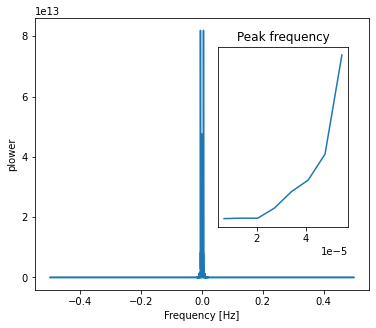

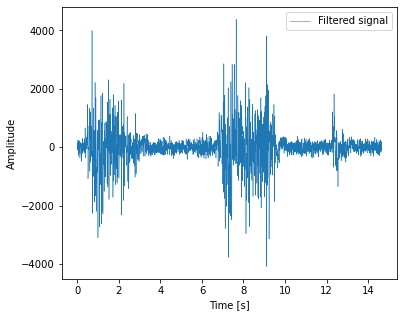

In [6]:
def filter_plot(path):
    path = str(path)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()
    Time = np.linspace(0, len(signal) / fs, num=len(signal))
    sig = signal 
    sig_fft = fftpack.fft(sig)
    power = np.abs(sig_fft)**2
    period = 5

    # The corresponding frequencies
    sample_freq = fftpack.fftfreq(sig.size)

    # Plot the FFT power
    plt.figure(figsize=(6, 5))
    plt.plot(sample_freq, power)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('plower')

    # Find the peak frequency: we can focus on only the positive frequencies
    pos_mask = np.where(sample_freq > 0)
    freqs = sample_freq[pos_mask]
    peak_freq = freqs[power[pos_mask].argmax()]

    # Check that it does indeed correspond to the frequency that we generate
    # the signal with
    np.allclose(peak_freq, 1./period)

    # An inner plot to show the peak frequency
    axes = plt.axes([0.55, 0.3, 0.3, 0.5])
    plt.title('Peak frequency')
    plt.plot(freqs[:8], power[:8])
    plt.setp(axes, yticks=[])   

    high_freq_fft = sig_fft.copy()
    high_freq_fft[np.abs(sample_freq) > peak_freq] = 0
    filtered_sig = fftpack.ifft(high_freq_fft)

    plt.figure(figsize=(6, 5))
    plt.plot(Time, filtered_sig, linewidth=0.5, label='Filtered signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    plt.legend(loc='best')
filter_plot("/Users/martinhuang/Desktop/OneDrive/2022/2022 Sem 1/DATA3888/Brain 5/Brain/arm_signal/EEU.wav")


In [8]:
def prep_wave(path):
    path = str(path)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()

    time = np.linspace(0, len(signal) / fs, num=len(signal))
    return signal, fs, time, spf 

def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.3*fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
    
def fft(path, cutoff = 5, plot = False):
    t = 5
    path = str(path)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()
    Time = np.linspace(0, len(signal) / fs, num=len(signal))
    sig = signal 
    cutoff = cutoff
    order = 2
    y = butter_lowpass_filter(signal, cutoff, fs, order)

    if plot == True:
        fig = go.Figure()
        fig.add_trace(go.Scatter(
                    y = signal,
                    line =  dict(shape =  'spline' ),
                    name = 'signal with noise'
                    ))
        fig.add_trace(go.Scatter(
                    y = y,
                    line =  dict(shape =  'spline' ),
                    name = 'filtered signal'
                    ))

        fig.show()
    return y, Time 

    
    

In [9]:

def movement_classifier(data, time, down_sample_rate = 50, window_size = 0.3, threshold_events = 100, difference = 0.4):
    # 1. Down Sampling
    ind = np.arange(0, np.where(np.round(time,4) == round(time[len(time) - 1] - window_size, 4))[0][0], down_sample_rate)
    t_stat = [0]*len(ind)

    # 2. Calculating SD
    for i in range(len(ind)):
        data_subset = data[ind[i] : ind[i] + int(window_size * down_sample_rate)]
        t_stat[i] = np.std(data_subset)

    # 3. Use threshold to determine movement intervals
    predicted_event = [x for x in range(len(t_stat)) if t_stat[x] > threshold_events]

    # time vector for middle of each window 
    time_middle = []
    for i in predicted_event:
        time_middle.append(time[ind[i]] + window_size/2)

    # 4. Estimation 
    intervals = [] 
    cut_point = predicted_event[0]
    last_interval = 0

    middle_time = int(down_sample_rate * window_size/2)
    for i in range(len(predicted_event) - 1):
        if predicted_event[i+1] != predicted_event[i] + 1:
            # combine intervals together if the predicted intervals are with difference amount
            if last_interval == 0:
                intervals.append([int(ind[cut_point] + middle_time)/10000, int(ind[predicted_event[i]] + middle_time)/10000])
                last_interval = intervals[-1]
            else:
                if ((int(ind[cut_point] + middle_time)/10000) - last_interval[1]) < difference:
                    last_interval[1] = int(ind[predicted_event[i]] + middle_time)/10000
                else:
                    intervals.append([int(ind[cut_point] + middle_time)/10000, int(ind[predicted_event[i]] + middle_time)/10000])
                last_interval = intervals[-1]
            
            cut_point = predicted_event[i+1]
                    
    return intervals

# Preparing Wave File

In [ ]:
def prep_wave(path):
    path = str(path)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()

    time = np.linspace(0, len(signal) / fs, num=len(signal))
    return signal, time 

In [ ]:
def predict(intervals):
    for i in range(len(intervals)):
        if intervals[i][1] - intervals[i][0] < 1:
            print("Turn")
        elif intervals[i][1] - intervals[i][0] >= 1:
            print("Tension")

In [ ]:
signal_EEU, time = fft("arm_signal/EEU.wav", plot = False)
predict(movement_classifier(signal_EEU, time, down_sample_rate = 80, window_size = 0.5, threshold_events = 12, difference = 1.3)
)

Tension
Tension
Turn


In [ ]:
signal_EUE, time = fft("arm_signal/EUE.wav")
predict(movement_classifier(signal_EUE, time, down_sample_rate = 80, window_size = 0.5, threshold_events = 12, difference = 1.3)
)

Tension
Turn
Tension


In [ ]:
signal_EUU, time = fft("arm_signal/EUU.wav")
predict(movement_classifier(signal_EUU, time, down_sample_rate = 80, window_size = 0.5, threshold_events = 12, difference = 1.3)
)

Tension
Turn
Turn


In [ ]:
signal_UEE, time = fft("arm_signal/UEE.wav")
predict(movement_classifier(signal_UEE, time, down_sample_rate = 80, window_size = 0.5, threshold_events = 12, difference = 1.3))

Turn
Tension
Tension


In [ ]:
signal_UEU, time = fft("arm_signal/UEU.wav")
predict(movement_classifier(signal_UEU, time, down_sample_rate = 80, window_size = 0.5, threshold_events = 12, difference = 1.3))

Turn
Tension
Turn


In [ ]:
signal_UUE, time = fft("arm_signal/UUE.wav")
predict(movement_classifier(signal_UUE, time, down_sample_rate = 80, window_size = 0.5, threshold_events = 12, difference = 1.3))


Turn
Turn
Tension


[1.266, 1.538]

In [ ]:
signal_UUU, time = fft("arm_signal/UUU.wav")
predict(movement_classifier(signal_UUU, time, down_sample_rate = 80, window_size = 0.5, threshold_events = 12, difference = 1.3))

Turn
Turn
Turn


In [ ]:
def extract_signal(limit, data):
    if limit[0] >= limit[1]:
        print("Error")
        return [0] 
    ret_data = []
    for i in range(len(data)):
        if i >= limit[0] and i < limit[1]:
            ret_data.append(data[i])
    return ret_data

In [ ]:
signal_UUU, time = fft("arm_signal/UUU.wav")
intervals = movement_classifier(signal_UUU, time, down_sample_rate = 80, window_size = 0.5, threshold_events = 12, difference = 1.3)
print(intervals[0])

a = extract_signal(intervals[1], signal_UUU)
print(a)

[0.666, 0.986]
[56.527862172953775]


# Finish Classifier


In [ ]:
def predict_wave(path,down_sample_rate = 80, window_size = 0.5, threshold_events = 12, difference = 1.3, plot = False, cutoff = 5):
    t = 5
    path = str(path)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()
    time = np.linspace(0, len(signal) / fs, num=len(signal))
    sig = signal 
    cutoff = cutoff
    order = 2
    data  = butter_lowpass_filter(signal, cutoff, fs, order)

    if plot == True:
        fig = go.Figure()
        fig.add_trace(go.Scatter(
                    y = signal,
                    line =  dict(shape =  'spline' ),
                    name = 'signal with noise'
                    ))
        fig.add_trace(go.Scatter(
                    y = data,
                    line =  dict(shape =  'spline' ),
                    name = 'filtered signal'
                    ))

        fig.show()
    # 1. Down Sampling
    ind = np.arange(0, np.where(np.round(time,4) == round(time[len(time) - 1] - window_size, 4))[0][0], down_sample_rate)
    t_stat = [0]*len(ind)
    # 2. Calculating SD
    for i in range(len(ind)):
        data_subset = data[ind[i] : ind[i] + int(window_size * down_sample_rate)]
        t_stat[i] = np.std(data_subset)
    # 3. Use threshold to determine movement intervals
    predicted_event = [x for x in range(len(t_stat)) if t_stat[x] > threshold_events]
    # time vector for middle of each window 
    time_middle = []
    for i in predicted_event:
        time_middle.append(time[ind[i]] + window_size/2)
    # 4. Estimation 
    intervals = [] 
    cut_point = predicted_event[0]
    last_interval = 0
    middle_time = int(down_sample_rate * window_size/2)
    for i in range(len(predicted_event) - 1):
        if predicted_event[i+1] != predicted_event[i] + 1:
            # combine intervals together if the predicted intervals are with difference amount
            if last_interval == 0:
                intervals.append([int(ind[cut_point] + middle_time)/10000, int(ind[predicted_event[i]] + middle_time)/10000])
                last_interval = intervals[-1]
            else:
                if ((int(ind[cut_point] + middle_time)/10000) - last_interval[1]) < difference:
                    last_interval[1] = int(ind[predicted_event[i]] + middle_time)/10000
                else:
                    intervals.append([int(ind[cut_point] + middle_time)/10000, int(ind[predicted_event[i]] + middle_time)/10000])
                last_interval = intervals[-1]
            
            cut_point = predicted_event[i+1]             
    for i in range(len(intervals)):
        if intervals[i][1] - intervals[i][0] < 1:
            print("Turn")
        elif intervals[i][1] - intervals[i][0] >= 1:
            print("Tension")
    
  


In [ ]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [56]:
def accuracy(folder_path = "arm_signal/", down_sample_rate = 80, window_size = 0.5, threshold_events = 12, difference = 1.3, cutoff = 5):
    path = str(folder_path)
    directory = os.fsencode(path)
    accuracy = []
    number_of_files = 0
    for file in os.listdir(directory):
        number_of_files += 1
        filename = os.fsdecode(file)
        if filename.endswith(".wav") == False:
               continue 
        else:
            path = str(folder_path + filename)
            spf = wave.open(path, "r")
            signal = spf.readframes(-1)
            signal = np.frombuffer(signal, np.int16)
            fs = spf.getframerate()
            time = np.linspace(0, len(signal) / fs, num=len(signal))
            cutoff = cutoff
            order = 2
            data  = butter_lowpass_filter(signal, cutoff, fs, order)
            # 1. Down Sampling
            ind = np.arange(0, np.where(np.round(time,4) == round(time[len(time) - 1] - window_size, 4))[0][0], down_sample_rate)
            t_stat = [0]*len(ind)
            # 2. Calculating SD
            for i in range(len(ind)):
                data_subset = data[ind[i] : ind[i] + int(window_size * down_sample_rate)]
                t_stat[i] = np.std(data_subset)
            # 3. Use threshold to determine movement intervals
            predicted_event = [x for x in range(len(t_stat)) if t_stat[x] > threshold_events]
            # time vector for middle of each window 
            time_middle = []
            for i in predicted_event:
                time_middle.append(time[ind[i]] + window_size/2)
            # 4. Estimation 
            intervals = [] 
            cut_point = predicted_event[0]
            last_interval = 0
            middle_time = int(down_sample_rate * window_size/2)
            for i in range(len(predicted_event) - 1):
                if predicted_event[i+1] != predicted_event[i] + 1:
                    # combine intervals together if the predicted intervals are with difference amount
                    if last_interval == 0:
                        intervals.append([int(ind[cut_point] + middle_time)/10000, int(ind[predicted_event[i]] + middle_time)/10000])
                        last_interval = intervals[-1]
                    else:
                        if ((int(ind[cut_point] + middle_time)/10000) - last_interval[1]) < difference:
                            last_interval[1] = int(ind[predicted_event[i]] + middle_time)/10000
                        else:
                            intervals.append([int(ind[cut_point] + middle_time)/10000, int(ind[predicted_event[i]] + middle_time)/10000])
                        last_interval = intervals[-1]
                    cut_point = predicted_event[i+1] 
          
          
            correct = filename.split(".")[0] 
            correct = ''.join([i for i in correct if not i.isdigit()])
            correct_answer = list(correct)
            estimate = [] 
            for i in range(len(intervals)):
                if intervals[i][1] - intervals[i][0] < 1:
                    estimate.append("U")
                elif intervals[i][1] - intervals[i][0] >= 1:
                    estimate.append("E")
            # counter = 0
            # acc = 0
            # for i in correct_answer:
            #     if counter > len(correct_answer):
            #         continue
            #     if counter <= len(correct_answer):
            #         if i == estimate[counter]:
            #             acc += 1
            #             counter += 1
            #         else:
            #             counter += 1
 
            # similar(correct_answer, estimate)
        # accuracy.append(acc/len(correct_answer))
        accuracy.append(similar(correct_answer, estimate))
    plt.boxplot(accuracy)
    plt.show()
    nparr = np.array(accuracy)
    acc_value = np.sum(nparr)/len(nparr)
    # acc_value = sum(int(accuracy))/len(accuracy)
    print("Accuracy is", round(acc_value,3), "from",number_of_files,"files and",number_of_files*len(correct_answer),"events.")    
        
        


            
            
     

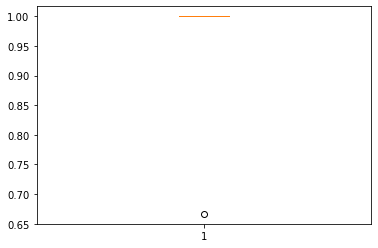

Accuracy is 0.986 from 24 files and 72 events.


In [57]:
accuracy()

In [ ]:
# signal,time = prep_wave("arm_signal/UUU.wav")

wave_seq_short_whole = [] 
intervals_whole = [] 
transformed = [] 
sample_rate = 10000

folder_path = "arm_signal/"
path = str(folder_path)
directory = os.fsencode(path)
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".wav") == False:
        continue 
    path = str(folder_path + filename)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()
    time = np.linspace(0, len(signal) / fs, num=len(signal))
    cutoff = 5
    order = 2
    data  = butter_lowpass_filter(signal, cutoff, fs, order)
    intervals = movement_classifier(data, time, 80,0.5,12,1.3) 
    intervals_whole.extend(intervals)   

    wave_seq_short = [] 
    for i in range(len(intervals)):
        wave_seq_short.append(extract_signal(intervals[i], data))
    wave_seq_short_whole.extend(wave_seq_short)
    print(filename, len(wave_seq_short))


panel_whole = pd.DataFrame(columns = ['unique_id','ds','y'])
for i in range(len(wave_seq_short_whole)):
    if intervals_whole[i][0] < intervals_whole[i][1]:
        unique_id = [i]*len(wave_seq_short_whole[i])
        time = np.arange(intervals_whole[i][0],intervals_whole[i][1])/sample_rate 
        panel = pd.DataFrame(data = {'unique_id':unique_id,
                                     'ds':time,
                                     'y':wave_seq_short[i]})
        panel_whole = panel_whole.append(panel, ignore_index = True)

print("Done")

UUE2.wav 3
UUE3.wav 3
UEU2.wav 3
UEU3.wav 3
EEE.wav 3
EEU2.wav 3
UUU.wav 3
EEU3.wav 3
EUE2.wav 3
UUE.wav 3
EUE3.wav 3
EEU.wav 3
UEE3.wav 3
UEE2.wav 3
UUU3.wav 3
UUU2.wav 3
EUU3.wav 3
EUU.wav 3
EUU2.wav 3
UEE.wav 3
UEU.wav 3
EEE3.wav 3
EUE.wav 3
EEE2.wav 3
1
1
2
1
1
2
1
2
1
0
1


IndexError: list index out of range

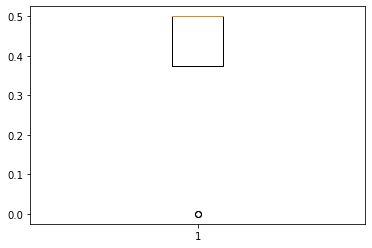

Accuracy is 0.375 from 8 files and 24 events.


In [46]:
accuracy(folder_path = "elbw/")

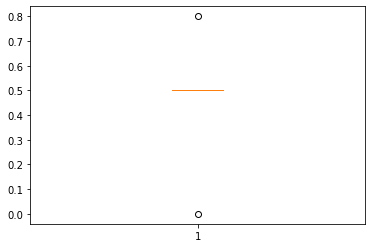

Accuracy is 0.475 from 8 files and 24 events.


In [47]:
accuracy("shoulder/")

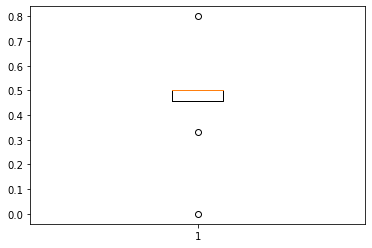

Accuracy is 0.454 from 8 files and 24 events.


In [48]:
accuracy("wrist/")

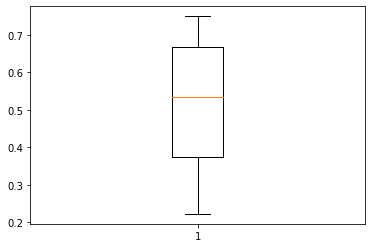

Accuracy is 0.521 from 11 files and 55 events.


In [49]:
accuracy("5/")

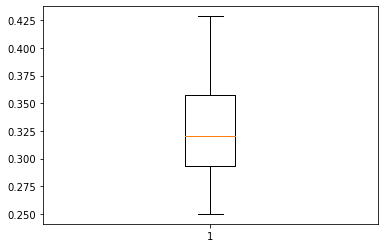

Accuracy is 0.33 from 5 files and 50 events.


In [50]:
accuracy("10/")

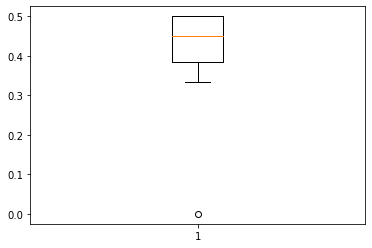

Accuracy is 0.392 from 8 files and 24 events.


In [51]:
accuracy("Yuxuan/elbw/")

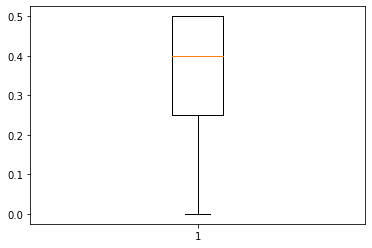

Accuracy is 0.329 from 8 files and 24 events.


In [52]:
accuracy("Yuxuan/shoulder/")

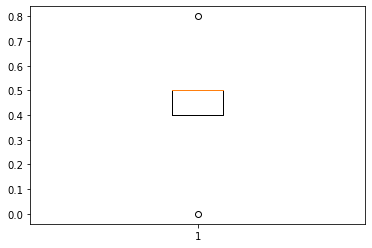

Accuracy is 0.45 from 8 files and 24 events.


In [53]:
accuracy("Yuxuan/wrist/")